# 4. Classifying Claims - Improving Results

At this stage, we will look at taking a few of our best-performing algorithms from our previous post and attempting to increase performance. 

As you may remember, the best-performing algorithms were:
* Naive Bayes - an accuracy of 58.90% (1.12% variance);
* SVM with non-linear kernel - an accuracy of 62.52% (0.80% variance); and
* Multilayer neural networks - an accuracy of 61.20% (0.54% variance).

Ths posts [here](https://machinelearningmastery.com/machine-learning-performance-improvement-cheat-sheet/) and [here](https://machinelearningmastery.com/improve-deep-learning-performance/) offer some suggestions for how to increase performance:
1. Improve Performance With Data.
2. Improve Performance With Algorithms.
3. Improve Performance With Algorithm Tuning.
4. Improve Performance With Ensembles.

We should also look at the time required to train our models. If a model is 10x faster to train, it may be preferable to another model with greater accuracy. 

## Load the Data

In [1]:
import pickle
with open("encoded_data.pkl", "rb") as f:
    print("Loading data")
    X, Y = pickle.load(f)
    print("{0} claims and {1} classifications loaded".format(len(X), len(Y)))

Loading data
11238 claims and 11238 classifications loaded


In [2]:
import numpy as np
# Convert one hot to target integer
Y_integers = np.argmax(Y, axis=1)

## Naive Bayes to Start

It turns out that there are not too many parameters we can vary for a Naive Bayes classifier. In fact, in scikit-learn there is only one tuneable parameter - alpha - that sets an amount of additive smoothing (see the documentation [here](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

The smoothing is set to 1.0 as a default. Let's have a look at performance if we turn this off by setting the alpha parameter to 0.

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

scores = cross_val_score(MultinomialNB(alpha=1.0e-3), X, Y_integers, cv=5)
      
print(
        "NB with alpha = 0 has an average classification accuracy of {0:.2f} ({1:.2f})".format(
            scores.mean()*100, 
            scores.std()*100
        )    
)

NB with alpha = 0 has an average classification accuracy of 58.94 (0.43)


As we can see changing this parameter doesn't seem to have that much effect.

## Improving Performance with Algorithms

Now, scikit-learn provides a rather simple multi-layer neural network implementation. To improve performance we can experiment with more advanced neural network architectures.  

Questions we can ask include:
* Does changing the number of hidden layers increase performance?
* Does using Dropout increase performance?
* Does changing the dimensionality of our hidden layers increase performance?

Keras is an excellent library for experimenting with deep learning models. We will play around using that. This post [here](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/) explains how we can perform k-fold validation with keras models.

In [4]:
input_dim = X.shape[1]
print("Our input dimension for our claim representation is {0}".format(input_dim))

no_classes = Y.shape[1]
print("Our output dimension is {0}".format(no_classes))

Our input dimension for our claim representation is 5000
Our output dimension is 8


### Keras Model

Before attempting cross-validation, let's build and explore a Keras model.  

This post [here](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) provides help for obtaining training metrics as Keras callback data and plotting those metrics.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 500)               2500500   
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 4008      
Total params: 2,504,508
Trainable params: 2,504,508
Non-trainable params: 0
_________________________________________________________________
Train on 8990 samples, validate on 2248 samples
Epoch 1/10
8990/8990 [==============================] - 298s - loss: 1.1831 - acc: 0.5908 - val_loss: 1.1081 - val_acc: 0.6161
Epoch 2/10
8990/8990 [==============================] - 297s - loss: 0.3009 - acc: 0.8979 - val_loss: 1.5360 - val_acc: 0.6090
Epoch 3/10
8990/8990 [==============================] - 294s - loss: 0.0672 - acc: 0.9850 - val_loss: 1.8990 - val_acc: 0.6174
Epoch 4/10
8990/8990 [==============================] - 298s - loss: 0.0364 - acc: 0.9932 - val_los

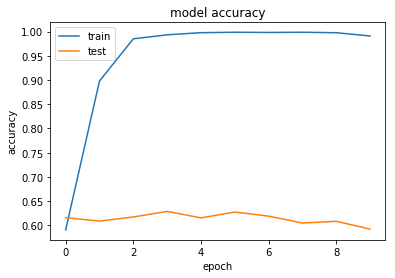

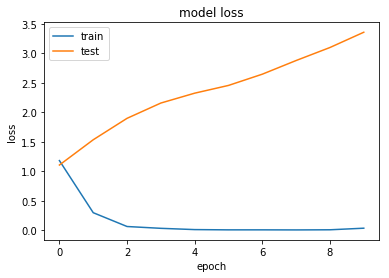

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt

def keras_model():
    # create model
    model = Sequential()
    model.add(Dense(500, input_dim=input_dim, activation='relu'))
    model.add(Dense(no_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = keras_model()
model.summary()
history = model.fit(X, Y, validation_split=0.2, epochs=10, batch_size=5, verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Overfitting

Looking at this first set of results we can see that our neural network quickly overfits the data, while the test performance stays reasonably constant.  

One way to reduce overfitting is to [apply Dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/). Let's try that now.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               2500500   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 4008      
Total params: 2,504,508
Trainable params: 2,504,508
Non-trainable params: 0
_________________________________________________________________
Train on 8990 samples, validate on 2248 samples
Epoch 1/10
8990/8990 [==============================] - 297s - loss: 1.2949 - acc: 0.5539 - val_loss: 1.0363 - val_acc: 0.6326
Epoch 2/10
8990/8990 [==============================] - 277s - loss: 0.6315 - acc: 0.7833

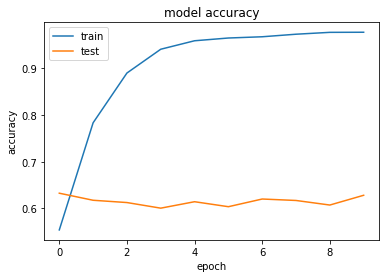

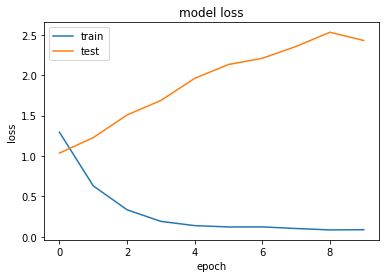

In [11]:
from keras.layers import Dropout

def keras_dropout_model():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(input_dim,)))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(no_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = keras_dropout_model()
model.summary()
history = model.fit(X, Y, validation_split=0.2, epochs=10, batch_size=5, verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now let's try with a more aggressive level of Dropout.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               2500500   
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 4008      
Total params: 2,504,508
Trainable params: 2,504,508
Non-trainable params: 0
_________________________________________________________________
Train on 8990 samples, validate on 2248 samples
Epoch 1/10
8990/8990 [==============================] - 289s - loss: 1.5896 - acc: 0.4839 - val_loss: 1.1905 - val_acc: 0.5778
Epoch 2/10
8990/8990 [==============================] - 288s - loss: 1.1707 - acc: 0.5999

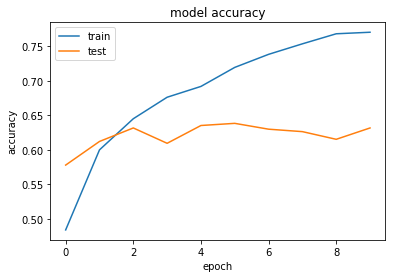

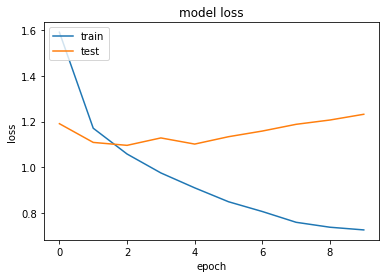

In [12]:
from keras.layers import Dropout

def keras_dropout_model():
    # create model
    model = Sequential()
    model.add(Dropout(0.5, input_shape=(input_dim,)))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(no_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = keras_dropout_model()
model.summary()
history = model.fit(X, Y, validation_split=0.2, epochs=10, batch_size=5, verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This seems to work a little bit better - but there is about 2-3% variance so it is difficult to tell. Maybe we can try to train for a number of additional epochs.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_5 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               2500500   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 4008      
Total params: 2,504,508
Trainable params: 2,504,508
Non-trainable params: 0
_________________________________________________________________
Train on 8990 samples, validate on 2248 samples
Epoch 1/20
8990/8990 [==============================] - 278s - loss: 1.6090 - acc: 0.4763 - val_loss: 1.1685 - val_acc: 0.6005
Epoch 2/20
8990/8990 [==============================] - 283s - loss: 1.1541 - acc: 0.6034

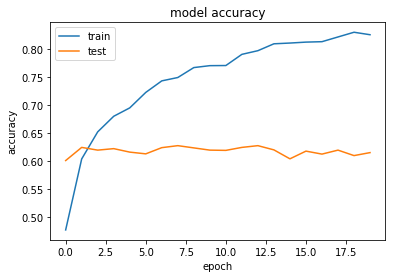

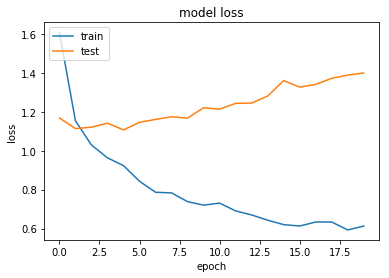

In [13]:
from keras.layers import Dropout

def keras_dropout_model():
    # create model
    model = Sequential()
    model.add(Dropout(0.5, input_shape=(input_dim,)))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(no_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = keras_dropout_model()
model.summary()
history = model.fit(X, Y, validation_split=0.2, epochs=20, batch_size=5, verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Okay so Dropout doesn't appear to improve our performance. Overfitting still occurs over time and the test accuracy appears stubbornly fixed at around 60-62%.

## Improving Performance with Algorithm Tuning

Let's explore a few architecture choices with our keras model to see if we can see any improvement. At this stage we are just looking for low-hanging fruit. If a particular direction looks promising, there is the option to use grid search routines to find optimal parameters. 

In [ ]:
def keras_multi_layer_model():
    # create model
    model = Sequential()
    model.add(Dense(1000, input_dim=input_dim, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(no_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = keras_multi_layer_model()
model.summary()
history = model.fit(X, Y, validation_split=0.2, epochs=10, batch_size=5, verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1000)              5001000   
_________________________________________________________________
dense_18 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_19 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 2008      
Total params: 5,628,758
Trainable params: 5,628,758
Non-trainable params: 0
_________________________________________________________________
Train on 8990 samples, validate on 2248 samples
Epoch 1/10
8990/8990 [==============================] - 647s - loss: 1.2164 - acc: 0.5645 - val_loss: 1.0894 - val_acc: 0.6277
Epoch 2/10
8990/8990 [==============================] - 632s - loss: 0.5716 - acc: 0.7991

In [8]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=keras_model, epochs=10, batch_size=16, verbose=1)
scores = cross_val_score(estimator, X, Y, cv=5)
      
print(
        "Keras Model with one hidden layer of dimensionality 500 has an average classification accuracy of {0:.2f} ({1:.2f})".format(
            scores.mean()*100, 
            scores.std()*100
        )    
)

KeyboardInterrupt: 

Note this takes a long time! Maybe I need to check on the time per epoch before running cross-validation.

## Increasing Performance with Data

Here are some steps we can try to improve performance by modifying our initial data:
1. Get more data - we have more data available and so we can maybe up our dataset to 50,000 randomly selected claims, or use each claim in each claimset as a data sample. The reason why we have tried to limit our dataset is due to time and memory concerns - if we up our dataset size these may need to be looked at.
2. Normalise the data - it may be worth looking into whether we can normalise our input X matrix values data to scale between 0 and 1. Our Y vector is already in a one-hot format and so cannot be normalised.
3. Changing our X dimensionality - is there any benefit in increasing or decreasing the dimensionality of our input data. For example, we can change the vocubulary cap on our text tokeniser.
4. Changing the form of our input data - what happens if we use (normalised) term frequency instead of TD-IDF? Could we represent our text data as a continuous bag of words (e.g. a sum of word vectors)?

## Increasing Performance with Ensembles

How do each of our preferred machine learning algorithms build their models? If they each have different strengths and weaknesses we may be able to build an ensemble model that outperforms the individual performance.

### Looking at the Confusion Matrix for Insights